### 변수 설정

In [1]:
image_wh = 480
batch_size = 16
checkpoint_path = "efficient2_m2_checkpoint.pth"

### GPU 9번 설정

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1" 

In [3]:
import torch

print(torch.cuda.is_available())

True


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### 필요 라이브러리 설치

In [5]:
import os.path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import copy
from tqdm import tqdm
import sys, time

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.autograd import Variable

import torchvision
from torchvision import datasets, transforms,models

from sklearn.model_selection import train_test_split

In [6]:
base_directory = "/home/j-j9s006"

# Data 불러오기

### DF 생성

###### K-FASHION

In [7]:
df = pd.read_csv(os.path.join(base_directory, "material-classification", "k-fashion-label-material.csv"), encoding='cp949')
df = df[['file', 'type_id']]

df.dropna(subset=['type_id'], axis=0, how='any' , inplace=True)
df['type_id'] = df['type_id'].astype(int)

df['Filepath'] = base_directory + "/datasets/k-fashion/"+ df['file']

df.head()

,file,type_id,Filepath
0,560358_3.png,8,/home/j-j9s006/datasets/k-fashion/560358_3.png
1,595006_1.png,8,/home/j-j9s006/datasets/k-fashion/595006_1.png
2,595016_1.png,8,/home/j-j9s006/datasets/k-fashion/595016_1.png
3,595026_1.png,8,/home/j-j9s006/datasets/k-fashion/595026_1.png
4,595036_1.png,8,/home/j-j9s006/datasets/k-fashion/595036_1.png


###### Deep Fashion In shop

In [8]:
add_df = pd.read_csv(os.path.join(base_directory,"material-classification", "deep-inshop-label-material.csv"), encoding='cp949')
add_df = add_df[['image_id', 'type_id']]

add_df.dropna(subset=['type_id'], axis=0, how='any' , inplace=True)
add_df['type_id'] = add_df['type_id'].astype(int)
add_df['Filepath'] = base_directory + "/datasets/deep-fashion/inshop/segment-results/"+ add_df['image_id']+".png"
add_df = add_df.rename(columns={'image_id': 'file'})
add_df.head()

,file,type_id,Filepath
0,SE0000465,2,/home/j-j9s006/datasets/deep-fashion/inshop/se...
1,SE0002122,2,/home/j-j9s006/datasets/deep-fashion/inshop/se...
2,SE0003682,2,/home/j-j9s006/datasets/deep-fashion/inshop/se...
3,SE0003874,2,/home/j-j9s006/datasets/deep-fashion/inshop/se...
4,SE0003875,2,/home/j-j9s006/datasets/deep-fashion/inshop/se...


In [9]:
df = pd.concat([df, add_df], ignore_index=True)

df.dropna(subset=['type_id'], axis=0, how='any' , inplace=True)

#### 무신사

In [10]:
add_df = pd.read_csv(os.path.join(base_directory,"material-classification", "mss-label-material.csv"), encoding='cp949')
add_df = add_df[['file_name', 'type_id']]

add_df.dropna(subset=['type_id'], axis=0, how='any' , inplace=True)
add_df['type_id'] = add_df['type_id'].astype(int)
add_df['Filepath'] = base_directory + "/datasets/material_mss_dataset/"+ add_df['file_name']+".png"
add_df = add_df.rename(columns={'file_name': 'file'})
add_df.head()

,file,type_id,Filepath
0,MSS0000002,8,/home/j-j9s006/datasets/material_mss_dataset/M...
1,MSS0000003,8,/home/j-j9s006/datasets/material_mss_dataset/M...
2,MSS0000004,8,/home/j-j9s006/datasets/material_mss_dataset/M...
3,MSS0000005,8,/home/j-j9s006/datasets/material_mss_dataset/M...
4,MSS0000006,8,/home/j-j9s006/datasets/material_mss_dataset/M...


In [11]:
df = pd.concat([df, add_df], ignore_index=True)

df.dropna(subset=['type_id'], axis=0, how='any' , inplace=True)

무신사 리뷰

In [12]:
add_df = pd.read_csv(os.path.join(base_directory,"material-classification", "mss-review-label-material.csv"), encoding='cp949')

add_df.dropna(subset=['type_id'], axis=0, how='any' , inplace=True)
# add_df = add_df[add_df['type_id'] != 1] # 면
# add_df = add_df[add_df['type_id'] != 2] # 니트
# add_df = add_df[add_df['type_id'] != 3] # 데님
add_df['type_id'] = add_df['type_id'].astype(int)
add_df['Filepath'] = base_directory + "/datasets/mss_review_dataset/seg_image/"+add_df['type_name']+"/"+ add_df['image_id']+".png"
add_df = add_df.rename(columns={'image_id': 'file'})
add_df = add_df[['file', 'type_id', 'Filepath']]
add_df.head()

,file,type_id,Filepath
0,MRE0000000000,0,/home/j-j9s006/datasets/mss_review_dataset/seg...
1,MRE0000000001,0,/home/j-j9s006/datasets/mss_review_dataset/seg...
2,MRE0000000002,0,/home/j-j9s006/datasets/mss_review_dataset/seg...
3,MRE0000000003,0,/home/j-j9s006/datasets/mss_review_dataset/seg...
4,MRE0000000004,0,/home/j-j9s006/datasets/mss_review_dataset/seg...


In [13]:
df = pd.concat([df, add_df], ignore_index=True)

df.dropna(subset=['type_id'], axis=0, how='any' , inplace=True)

In [14]:
# type_id 를 str로 수정
df['type_id'] = df['type_id'].astype(str)

### Custom data 정제 완료

In [17]:
print(df['type_id'].unique())

['8' '2' '3' '4' '0' '6' '5' '7' '1']


In [18]:
# type id별로 몇개의 데이터가 있는지 확인
print(df['type_id'].value_counts())

type_id
2    9606
3    7335
1    6627
5    5183
7    5114
8    3127
0    2920
4    2526
6    1568
Name: count, dtype: int64


### 이미지 데이터셋 총 개수 및 label 종류 수 확인

In [19]:
labels = df['type_id'].values.tolist()

label_list=[]
for i in labels:
    if i not in label_list:
        label_list.append(i)

print('The number of pictures:', df.shape[0])
print('The number of labels:', len(label_list))
print('Labels:', label_list)

The number of pictures: 44006
The number of labels: 9
Labels: ['8', '2', '3', '4', '0', '6', '5', '7', '1']


### 이미지 데이터 확인하기

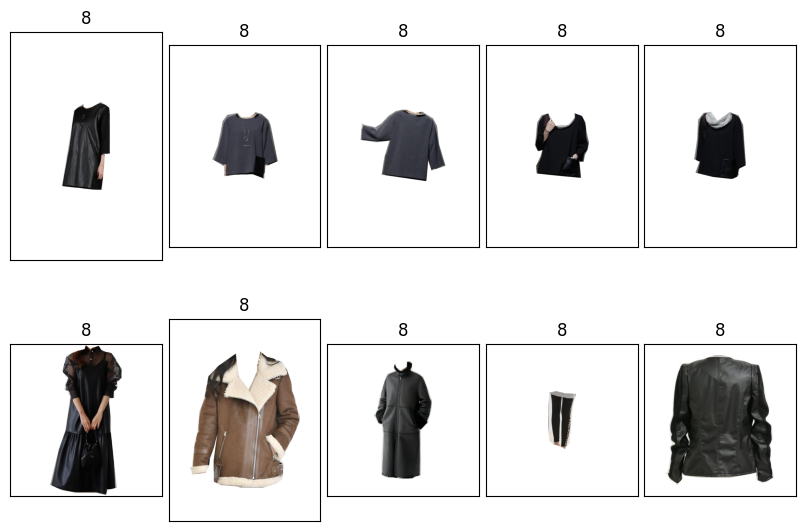

In [20]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(8, 6),
                         subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df['Filepath'].iloc[i]))
    ax.set_title(df['type_id'].iloc[i], fontsize=12)
    
plt.tight_layout(pad=0.5)

plt.show()

### train test valid 데이터 나누기

In [21]:
# train, test set으로 split(9대 1)
train_df,test_df = train_test_split(df, test_size=0.1,random_state=1234)


# train_df를 9대 1로 split(train과 valid로)
train_df, valid_df = train_test_split(train_df, test_size=0.1, random_state=1234)

### PYTORCH에서 쓰는 방식으로 변경

In [22]:
def load_paths_from_dataframe(df):
    image_paths = df['Filepath'].tolist()
    labels = df['type_id'].tolist()
    return image_paths, labels

In [23]:
# 데이터 로드
X_train, y_train = load_paths_from_dataframe(train_df)
X_test, y_test = load_paths_from_dataframe(test_df)
X_valid, y_valid = load_paths_from_dataframe(valid_df)

### 비율 확인

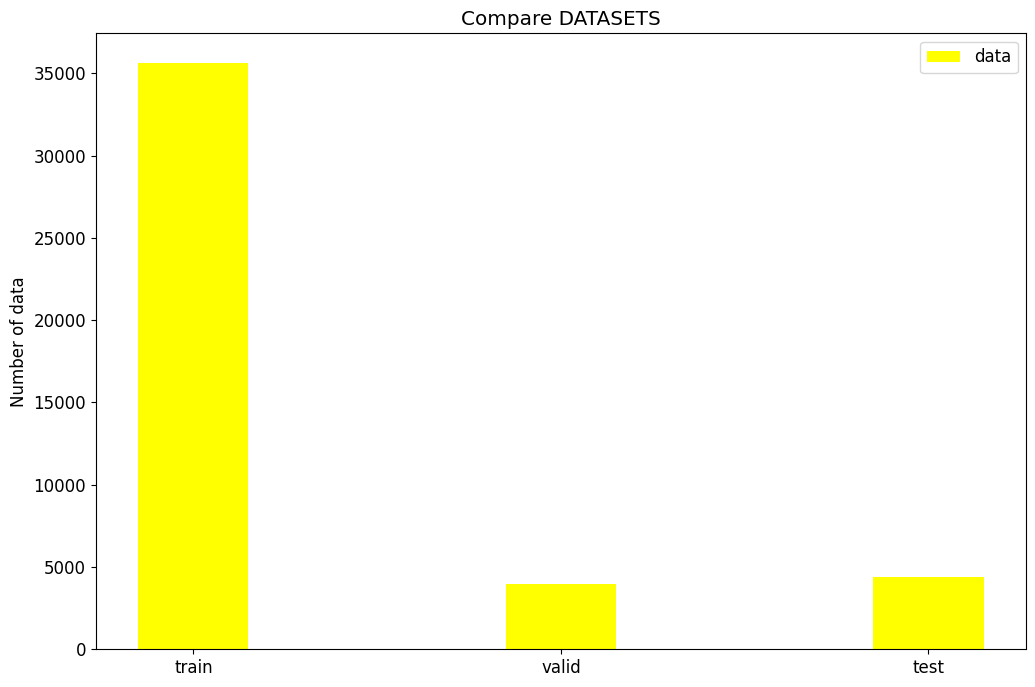

In [24]:
class compare_train_test_valid_dataset():
    
    def __init__(self,li):
        self.li = li
        self.len_train = len(li[0])
        self.len_valid = len(li[1])
        self.len_test = len(li[2])
        
    def __call__(self):
        #draw plt
        label = ['train', 'valid','test']
        data = [self.len_train,self.len_valid,self.len_test]
        plt.rcParams["font.size"] = 12
        plt.figure(figsize=(12,8))

        x = np.arange(len(label))

        plt.bar(x, [self.len_train,self.len_valid,self.len_test], label='data', width=0.3, color='#FFFF00')
        plt.legend()
        plt.xticks(x, label)
        plt.ylabel('Number of data')
        plt.title('Compare DATASETS')
        plt.show()

show =compare_train_test_valid_dataset([X_train,X_valid,X_test])
show()

# Aug Comporse

In [25]:
train_transform = transforms.Compose([
    transforms.Resize(image_wh),  
    transforms.RandomRotation(20),  # 20도 내외로 랜덤 회전
    transforms.RandomCrop(image_wh, padding=3), 
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
])

test_transform = transforms.Compose([
    transforms.Resize(image_wh),
    transforms.CenterCrop(image_wh), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
])


# DataSet

In [26]:
def rgba_to_rgb(image, background_color=(255, 255, 255)):
    if image.mode == 'RGBA':
        bg = Image.new('RGB', image.size, background_color)
        bg.paste(image, mask=image.split()[3])  # 3 is the alpha channel
        return bg
    else:
        return image

class clothes_Dataset(Dataset):
    def __init__(self, image_paths, y, transform=None):
        self.image_paths = image_paths
        self.label_list = y
        self.transform = transform

    def __len__(self):
        return len(self.label_list)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert('RGB')
        img = rgba_to_rgb(img)  # 이미지를 RGB로 변환
        label = int(self.label_list[idx])
                
#         print(img_path)
    
        if self.transform:
            img = self.transform(img)
            
        return img, label

In [27]:
image_paths_train, y_train = load_paths_from_dataframe(train_df)
image_paths_test, y_test = load_paths_from_dataframe(test_df)
image_paths_valid, y_valid = load_paths_from_dataframe(valid_df)

In [28]:
Trainset = clothes_Dataset(image_paths=image_paths_train, y=y_train, transform=train_transform)
Valset = clothes_Dataset(image_paths=image_paths_valid, y=y_valid, transform=test_transform)
Testset = clothes_Dataset(image_paths=image_paths_test, y=y_test, transform=test_transform)

In [29]:
trainloader = DataLoader(Trainset, batch_size=batch_size, shuffle=True, num_workers=2)
Valloader = DataLoader(Valset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(Testset, batch_size=batch_size, shuffle=False, num_workers=2)

In [30]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

def unnormalize(img):
    for i in range(3):  # RGB 채널에 대해서
        img[i] = img[i] * std[i] + mean[i]
    return img

def custom_imshow(img):
    img = unnormalize(img.numpy())  # 역정규화 적용
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()

# for i, (image, label) in enumerate(testloader):
#     if i > 20:
#         break
#     custom_imshow(image[0])

# Model 생성

In [31]:
print("PyTorch Version:", torch.__version__)
print("CUDA Version:", torch.version.cuda)

PyTorch Version: 2.0.1+cu117
CUDA Version: 11.7


In [32]:
weights = models.EfficientNet_V2_M_Weights.DEFAULT
model = models.efficientnet_v2_m(weights = weights)
model.classifier[1].out_features = len(label_list)

In [33]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)
model.to(device)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [34]:
print(model.classifier)

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1280, out_features=9, bias=True)
)


## train test valid 함수

#### Early Stopping

In [35]:
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0, path=checkpoint_path):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Validation loss decreased (improved) => Save the model'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [36]:
from tqdm import tqdm

def train(model, trainloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(enumerate(trainloader), total=len(trainloader))
    for i, data in pbar:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        accuracy = 100 * correct / total
        pbar.set_postfix({"Train Loss": running_loss / (i + 1), "Train Accuracy": accuracy})

    accuracy = 100 * correct / total

    return running_loss / len(trainloader), accuracy


def validate(model, validloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(enumerate(validloader), total=len(validloader))
    with torch.no_grad():
        for i, data in pbar:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            accuracy = 100 * correct / total
            pbar.set_postfix({"Validation Loss": running_loss / (i + 1), "Validation Accuracy": accuracy})

    accuracy = 100 * correct / total

    return running_loss / len(validloader), accuracy

In [37]:
early_stopping = EarlyStopping(patience=7)
num_epochs = 50
for epoch in range(num_epochs):
    train_loss, train_acc = train(model, trainloader, optimizer, criterion, device)
    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.2f}, Train Accuracy: {train_acc:.2f}%")

    val_loss, val_acc = validate(model, Valloader, criterion, device)
    print(f"Validation Loss: {val_loss:3f}, Validation Accuracy: {val_acc:.3f}%")
    
    early_stopping(val_loss, model)

    if early_stopping.early_stop:
        print("Early stopping")
        break

 19%|█▉        | 420/2228 [03:16<14:06,  2.14it/s, Train Loss=1.01, Train Accuracy=67.4]

KeyboardInterrupt



### Test

In [ ]:
from tqdm import tqdm

def test(model, dataframe, testloader, criterion, cloth_label):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
        
            probs = F.softmax(outputs, dim=1)  # 확률로 변환
            top3_probs, top3_labels = probs.topk(3, dim=1)  # 상위 3개의 확률과 라벨 추출
           
            loss = criterion(outputs, targets.long())
            test_loss += loss.data.cpu().numpy()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            acc = correct / total

            # 예측 결과와 원본 이미지를 시각화합니다.
            for local_idx, (top3_p, top3_l, actual) in enumerate(zip(top3_probs, top3_labels, targets)):
                try:
                    global_idx = batch_idx * testloader.batch_size + local_idx
                    original_image_path = dataframe.iloc[global_idx]['Filepath']
                    img = Image.open(original_image_path)
                    plt.imshow(img)
                    title_str = "Actual Label: {}\n".format(cloth_label[actual.cpu().item()])
                    for i in range(3):
                        title_str += "Predicted {}: {:.2f}% (Label: {})\n".format(i+1, top3_p[i].item()*100, cloth_label[top3_l[i].item()])
                    plt.title(title_str)
                    plt.show()
                except:
                    print(local_idx)
                    for i in range(3):
                        print(top3_l[i].item(), end=" ")
                    print()
                    

        epoch_loss = test_loss / len(testloader)
        epoch_acc = correct / total
        print('\ntest | Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))
        return epoch_acc, epoch_loss

In [ ]:
# Label 정보
cloth_label = {
    0: "Corduroy",
    1: "Cotton/Polyester",
    2: "Knit",
    3: "Denim",
    4: "Chiffon",
    5: "Padding",
    6: "Tweed",
    7: "Fleece",
    8: "Leather"
}

In [ ]:
# 이렇게 test 함수를 호출할 수 있습니다:
model.load_state_dict(torch.load(checkpoint_path))
test_accuracy, test_loss = test(model, test_df, testloader, criterion, cloth_label)

In [ ]:
# torch.save(model.state_dict(), 'mobilenet_v3_large_83.pth')